<h1>Santander Customer Transaction Prediction</h1>

## 1. Business Problem 

## 1.1 Description

At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

In this competition we are asked to predict if a customer will make a transaction or not regardless of the amount of money transacted. Hence our goal is to solve a binary classification problem. In the data description you can see that the features given are numeric and anonymized. The data provided for this competition has the same structure as the real data we have available to solve this problem.

<p style='font-size:18px'><b> Problem Statemtent </b></p>
we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/santander-customer-transaction-prediction/overview</p>

<h2> 1.2 Real World / Business Objectives and Constraints </h2>

1. Predict as many transaction as possible with high area under the ROC curve.
2. Interpretability is important
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/santander-customer-transaction-prediction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>train.csv</b> contains 202 columns: ID_code,Target,var_0,var_1,var_2,....var_199.<br />
<b>test.csv</b> contains the same columns but without the Target, which you are to predict.<br />
<b>Size of train.csv</b> - 288.14 MB<br />
<b>Size of test.csv</b> - 287.56 MB<br />
<b>Number of rows in train.csv</b> = 200000<br />
</pre>
You are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.

The task is to predict the value of target column in the test set.<br />
<br />

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan? </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/santander-customer-transaction-prediction/overview/evaluation

Metric(s): 
* AUC : https://en.wikipedia.org/wiki/Receiver_operating_characteristic

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [12]:
import gc
import os
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform
import xgboost as xgb

<h2> 3.1 Reading data and basic stats </h2>

In [13]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 200000


In [14]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [16]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


<h3> 3.2.1 Distribution of data points among output classes</h3>

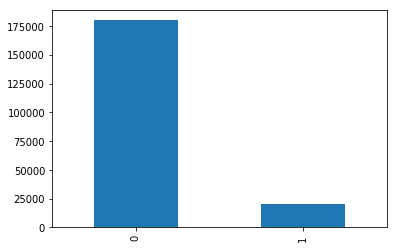

In [17]:
df['target'].value_counts().plot.bar()

The data is unbalanced with respect with target value.

In [18]:
print('~> % of where target = 0:\n   {}%'.format(100 - round(df['target'].mean()*100, 2)))
print('\n~> % of where target = 1:\n   {}%'.format(round(df['target'].mean()*100, 2)))

~> % of where target = 0:
   89.95%

~> % of where target = 1:
   10.05%


<h3> 3.2.2 Checking Missing Data

In [19]:
df.isna().sum().any()

False

- No missing points in train dataset

<h3> 3.2.3 Checking Duplicates Data

In [20]:
print('No of duplicates in train: {}'.format(sum(df.drop(['ID_code','target'], axis=1).duplicated())))

No of duplicates in train: 0


<h3> 3.2.4 Density plots of features </h3>
Let's show now the density plot of variables in train dataset.

We represent with different colors the distribution for values with target value 0 and 1

<Figure size 432x288 with 0 Axes>

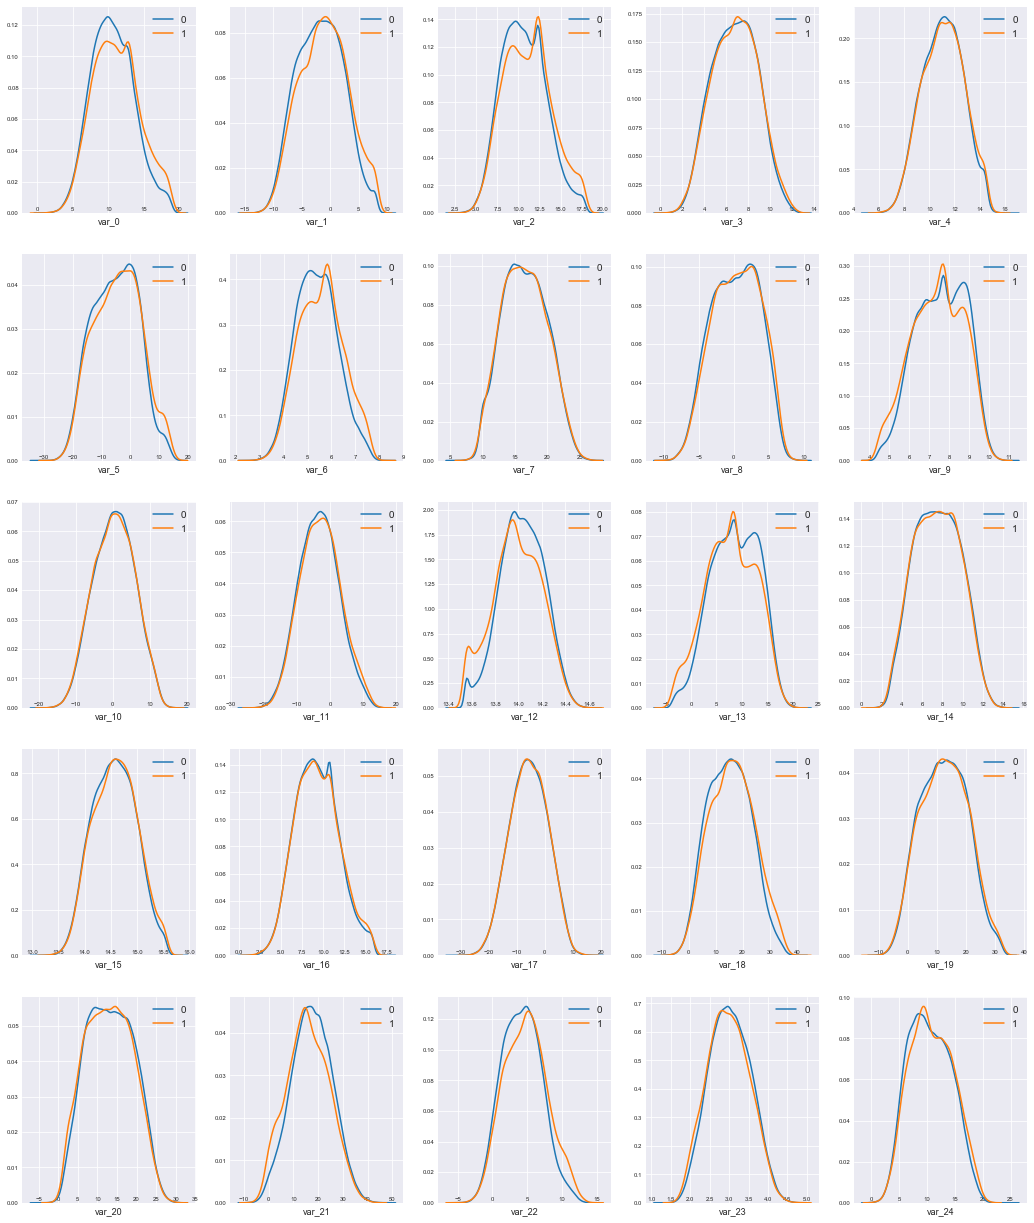

In [21]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
t0 = df.loc[df['target'] == 0]
t1 = df.loc[df['target'] == 1]
features = df.columns.values[2:27]

i = 0
sns.set_style('darkgrid')
plt.figure()
fig, ax = plt.subplots(10,10,figsize=(18,22))

for feature in features:
    i += 1
    plt.subplot(5,5,i)
    sns.distplot(t0[feature], hist=False,label='0')
    sns.distplot(t1[feature], hist=False,label='1')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show()

- We can observe that there is a considerable number of features with significant different distribution for the two target values.
- Also some features shows a distribution that resambles  to a bivariate distribution.

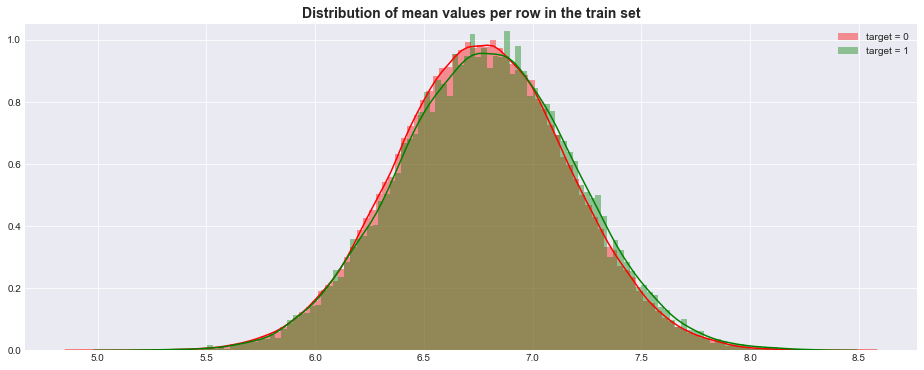

In [22]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
features = df.columns.values[2:202]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

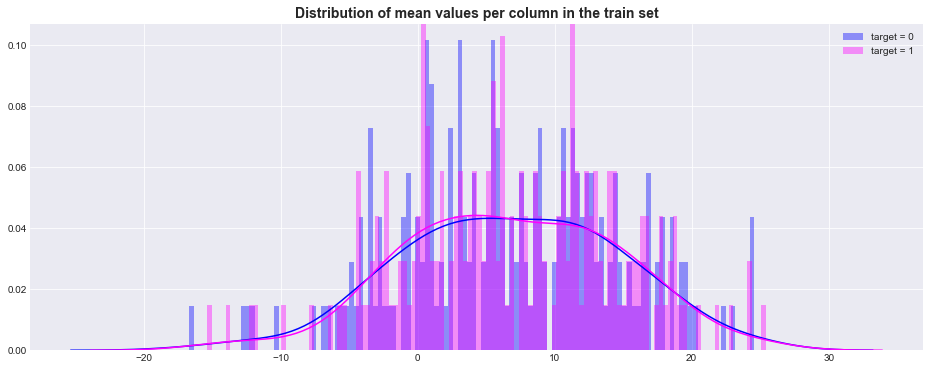

In [23]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="magenta", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

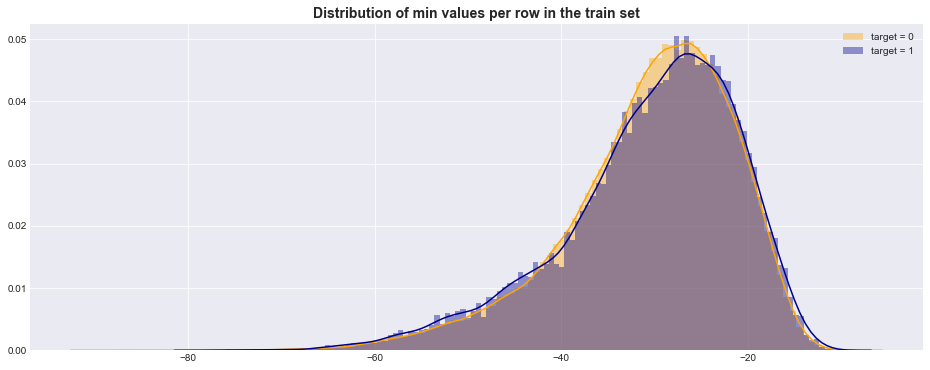

In [24]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

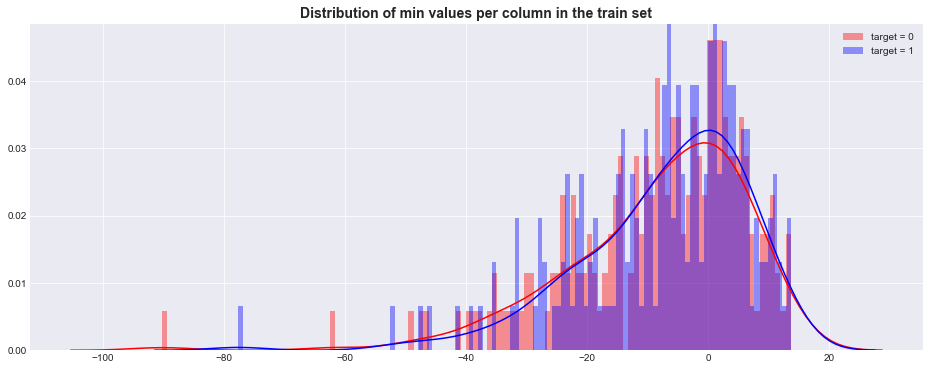

In [25]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

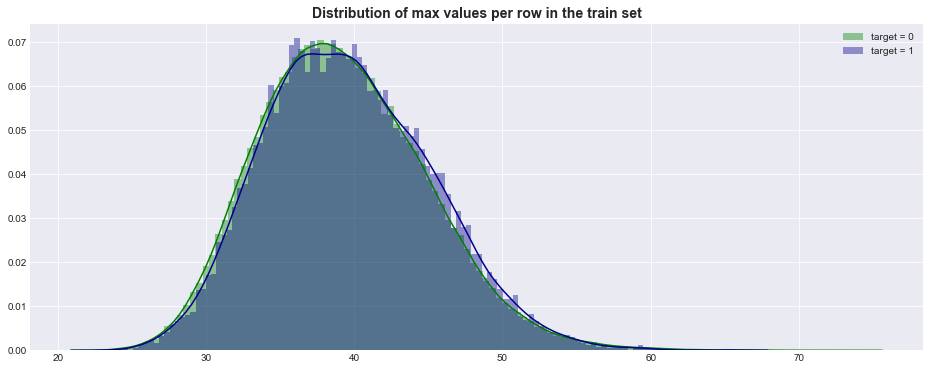

In [26]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].max(axis=1),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

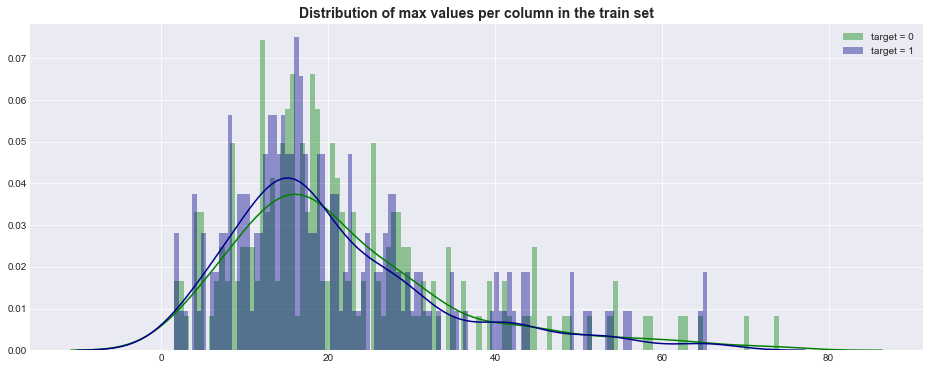

In [27]:
# observation & hints: https://www.kaggle.com/gpreda/santander-eda-and-prediction
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].max(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

<h3>Distribution of skew and kurtosis</h3>

Let's see now what is the distribution of skew values per rows and columns.

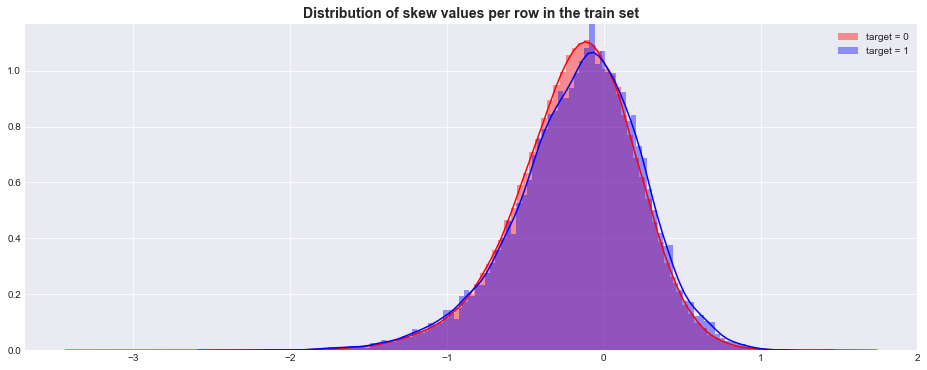

In [28]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

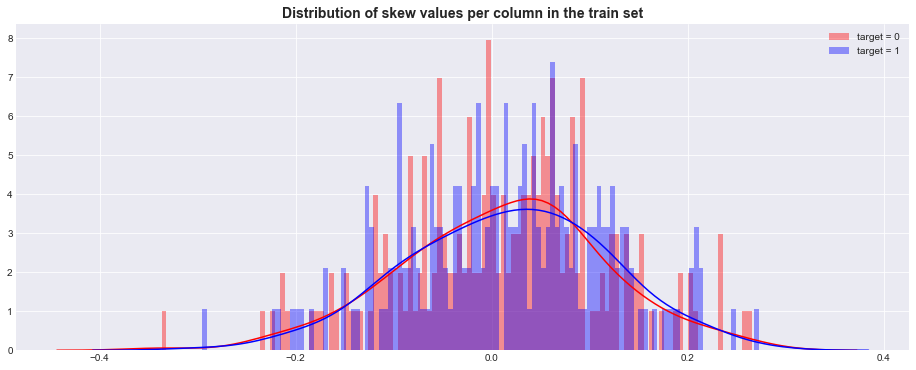

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

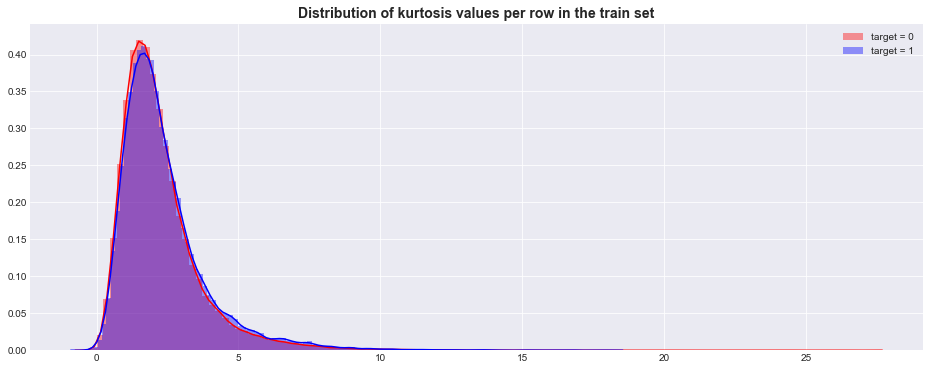

In [30]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

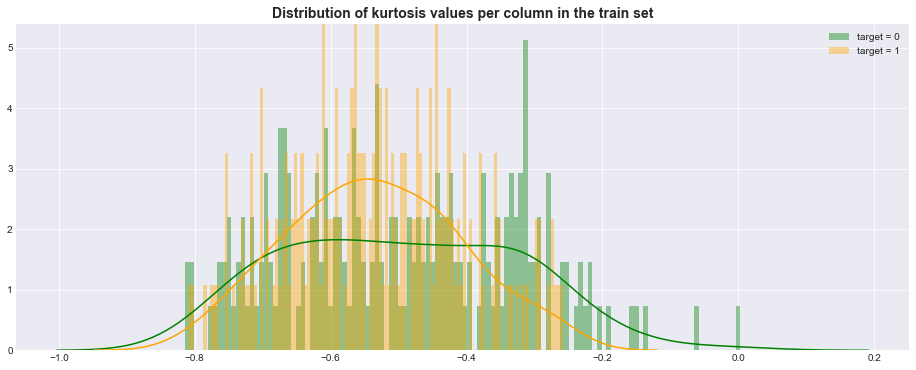

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set",fontweight='bold',fontsize=14)
sns.distplot(t0[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="orange", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

<h3> Observation </h3>

- All above observation like : Distribution of mean,min,max,skewness,kurtosis values for row and column significant different distribution for the two target values

<h2> 3 Visualisation in 2-D and 3-D using T-SNE </h2>

In [32]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE

In [22]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:10000]
y = df_subsampled['target'].values 
X = MinMaxScaler().fit_transform(df_subsampled.drop(['target','ID_code'],axis=1))

In [23]:
tsne2d = TSNE(perplexity=50,
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.292s...
[t-SNE] Computed neighbors for 10000 samples in 62.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.509537
[t-SNE] Computed conditional probabilities in 1.317s
[t-SNE] Iteration 50: error = 89.9922104, gradient norm = 0.0584660 (50 iterations in 19.271s)
[t-SNE]

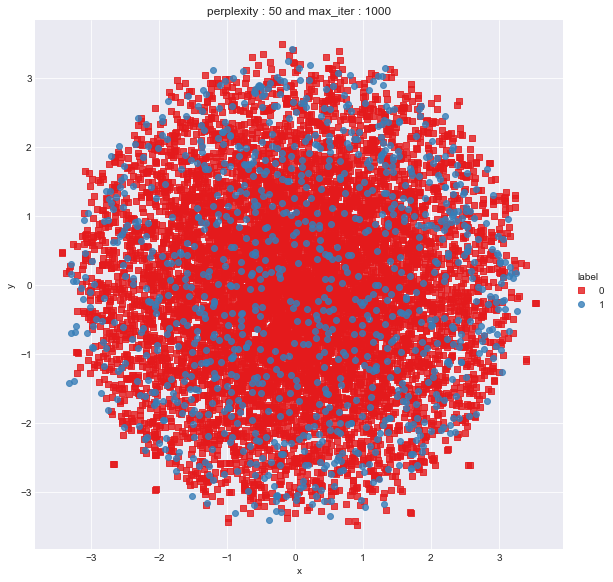

In [24]:
df1 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(50, 1000))
plt.show()

<h3> Observation </h3>

- Data not linear separable so we say that linear modal like logistic regression or SVM also not work.
- Here XGBoost, Random Forest, GBDT and LGB work good.

<h2> 4.Random split Train and CV Data </h2>

In [33]:
data = df.drop(['ID_code','target'],axis=1)
y_true = df['target']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [35]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in CV data :",X_cv.shape)

Number of data points in train data : (140000, 200)
Number of data points in CV data : (60000, 200)


In [36]:
print("Distribution of output variable in train data")
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*80)
print("Distribution of output variable in CV data")
cv_distr = Counter(y_cv)
cv_len = len(y_cv)
print("Class 0: ",int(cv_distr[0])/cv_len, "Class 1: ",int(cv_distr[1])/cv_len)

Distribution of output variable in train data
Class 0:  0.8995071428571428 Class 1:  0.10049285714285715
--------------------------------------------------------------------------------
Distribution of output variable in CV data
Class 0:  0.8995166666666666 Class 1:  0.10048333333333333


## 5. Modelling

## 5.1 Light GBM Classifier 

In [43]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='binary',n_jobs=-1)
param_dist = {"learning_rate" : uniform(0.001,0.3),
              "n_estimators" : sp_randint(100,1000),
              "max_depth"    : sp_randint(5,20),
              "min_child_weight": sp_randint(1,10),
              "gamma"        : uniform(0,0.03),
              "subsample"    : uniform(0.6,0.4),
              "reg_alpha"    : sp_randint(0,200),
              "reg_lambda"   : sp_randint(0,200),
              "colsample_bytree":uniform(0.6,0.3)}

lgb_random = RandomizedSearchCV(lgb_model, param_distributions=param_dist,cv=10,scoring='roc_auc',random_state=25,return_train_score= True)
lgb_random.fit(X_train,y_train)
print('mean CV scores',lgb_random.cv_results_['mean_test_score'])
print('mean train scores',lgb_random.cv_results_['mean_train_score'])

mean CV scores [0.88024583 0.87851069 0.88317939 0.87067304 0.8849789  0.88120278
 0.8777113  0.86111215 0.77092209 0.88061192]
mean train scores [0.95050896 0.9523733  0.95425431 0.93073338 0.95289449 0.97684795
 0.94801311 0.911143   0.80737657 0.94953221]


In [44]:
print(lgb_random.best_estimator_)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8400362967290745, gamma=0.004483331345083044,
               importance_type='split', learning_rate=0.07020278445544602,
               max_depth=11, min_child_samples=20, min_child_weight=1,
               min_split_gain=0.0, n_estimators=367, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=2,
               reg_lambda=171, silent=True, subsample=0.8103275853858888,
               subsample_for_bin=200000, subsample_freq=0)


In [47]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
                         colsample_bytree=0.8400362967290745, gamma=0.004483331345083044,
                         importance_type='split', learning_rate=0.07020278445544602,
                         max_depth=11, min_child_samples=20, min_child_weight=1,
                         min_split_gain=0.0, n_estimators=367, n_jobs=-1, num_leaves=31,
                         objective='binary', random_state=None, reg_alpha=2,
                         reg_lambda=171, silent=True, subsample=0.8103275853858888,
                         subsample_for_bin=200000, subsample_freq=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict_proba(X_train)[:,1]
y_cv_pred = clf.predict_proba(X_cv)[:,1]
print('Train AUC score : ',roc_auc_score(y_train,y_train_pred))
print('CV AUC score : ',roc_auc_score(y_cv,y_cv_pred))

Train AUC score :  0.9501392395519624
CV AUC score :  0.8824807806164148


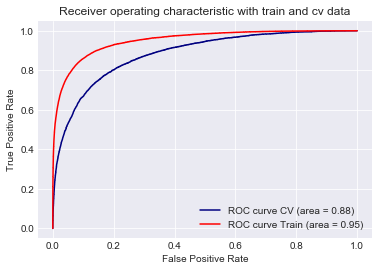

In [48]:
from sklearn.metrics import roc_curve, auc
fpr_tr,tpr_tr,ths = roc_curve(y_train,y_train_pred)
fpr_cv,tpr_cv,ths = roc_curve(y_cv,y_cv_pred)
auc_sc_tr = auc(fpr_tr, tpr_tr)
auc_sc_cv = auc(fpr_cv, tpr_cv)
plt.plot(fpr_cv, tpr_cv, color='navy',label='ROC curve CV (area = %0.2f)' % auc_sc_cv)
plt.plot(fpr_tr, tpr_tr, color='r', label='ROC curve Train (area = %0.2f)' % auc_sc_tr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with train and cv data')
plt.legend()
plt.show()

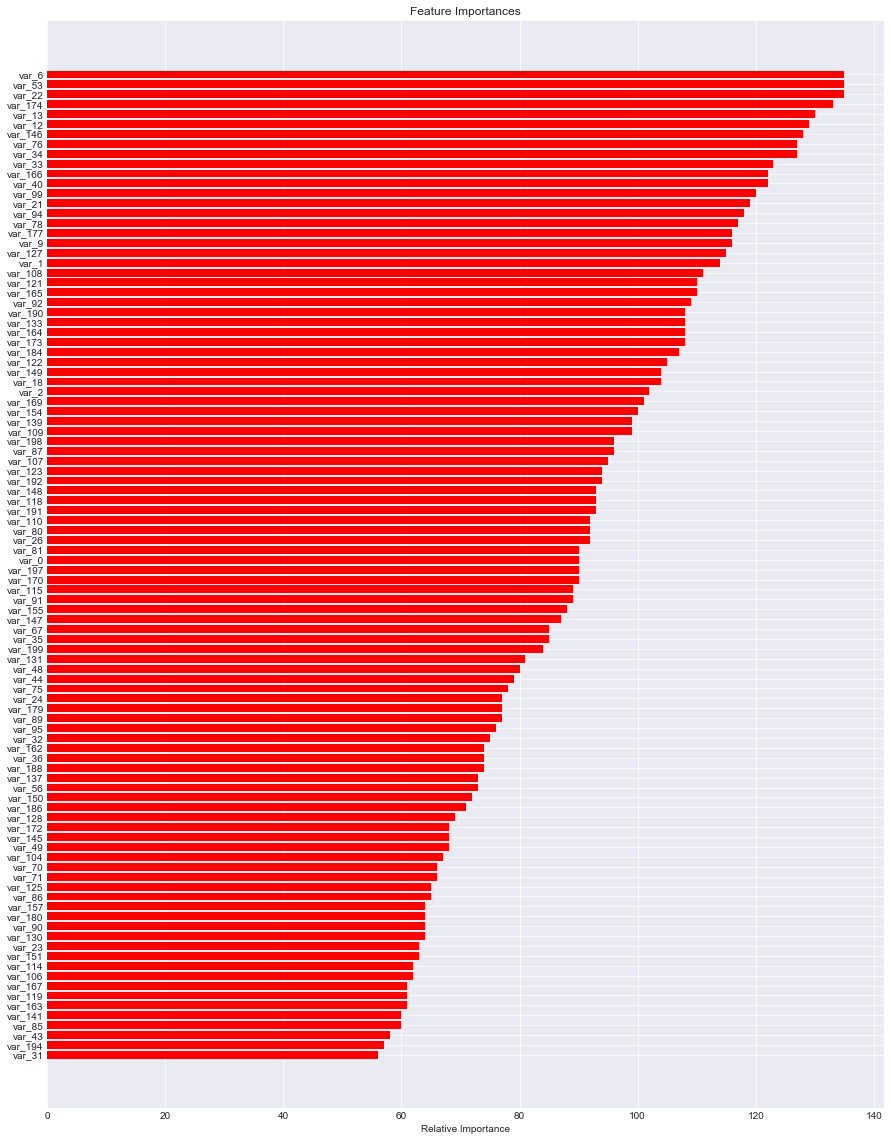

In [49]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-100:]
plt.figure(figsize=(15,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 5.2 Catboost

In [ ]:
import catboost as cb

cb_model = cb.CatBoostClassifier(objective="Logloss")
param_dist = {"learning_rate" : uniform(0.001,0.3),
              "n_estimators" : sp_randint(100,1000),
              "max_depth"    : sp_randint(1,10),
              "reg_lambda"   : sp_randint(0,200),
             "colsample_bylevel" : uniform(0.6,0.3)}

cb_random = RandomizedSearchCV(cb_model, param_distributions=param_dist,cv=10,scoring='roc_auc',random_state=25,return_train_score= True)
cb_random.fit(X_train,y_train)

In [38]:
print('mean CV scores',cb_random.cv_results_['mean_test_score'])
print('mean train scores',cb_random.cv_results_['mean_train_score'])

mean CV scores [0.89079037 0.88384732 0.88288483 0.8857749  0.88796739 0.89522415
 0.8575019  0.88467447 0.89463646 0.89432327]
mean train scores [0.92941715 0.9005922  0.89729407 0.89732055 0.90305196 0.91382172
 0.86898113 0.96610403 0.92906227 0.92116579]


In [39]:
print(cb_random.best_params_)

{'colsample_bylevel': 0.669454420022299, 'learning_rate': 0.2839739661135855, 'max_depth': 2, 'n_estimators': 831, 'reg_lambda': 177}


In [ ]:
clf = cb.CatBoostClassifier(colsample_bylevel=0.6694,
                            learning_rate=0.2839,max_depth=2,
                            n_estimators=831,reg_lambda=177)
clf.fit(X_train,y_train)

In [41]:
y_train_pred = clf.predict_proba(X_train)[:,1]
y_cv_pred = clf.predict_proba(X_cv)[:,1]
print('Train AUC score : ',roc_auc_score(y_train,y_train_pred))
print('CV AUC score : ',roc_auc_score(y_cv,y_cv_pred))

Train AUC score :  0.9124485254889182
CV AUC score :  0.8973694334454858


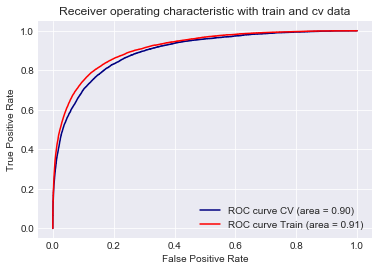

In [42]:
from sklearn.metrics import roc_curve, auc
fpr_tr,tpr_tr,ths = roc_curve(y_train,y_train_pred)
fpr_cv,tpr_cv,ths = roc_curve(y_cv,y_cv_pred)
auc_sc_tr = auc(fpr_tr, tpr_tr)
auc_sc_cv = auc(fpr_cv, tpr_cv)
plt.plot(fpr_cv, tpr_cv, color='navy',label='ROC curve CV (area = %0.2f)' % auc_sc_cv)
plt.plot(fpr_tr, tpr_tr, color='r', label='ROC curve Train (area = %0.2f)' % auc_sc_tr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with train and cv data')
plt.legend()
plt.show()

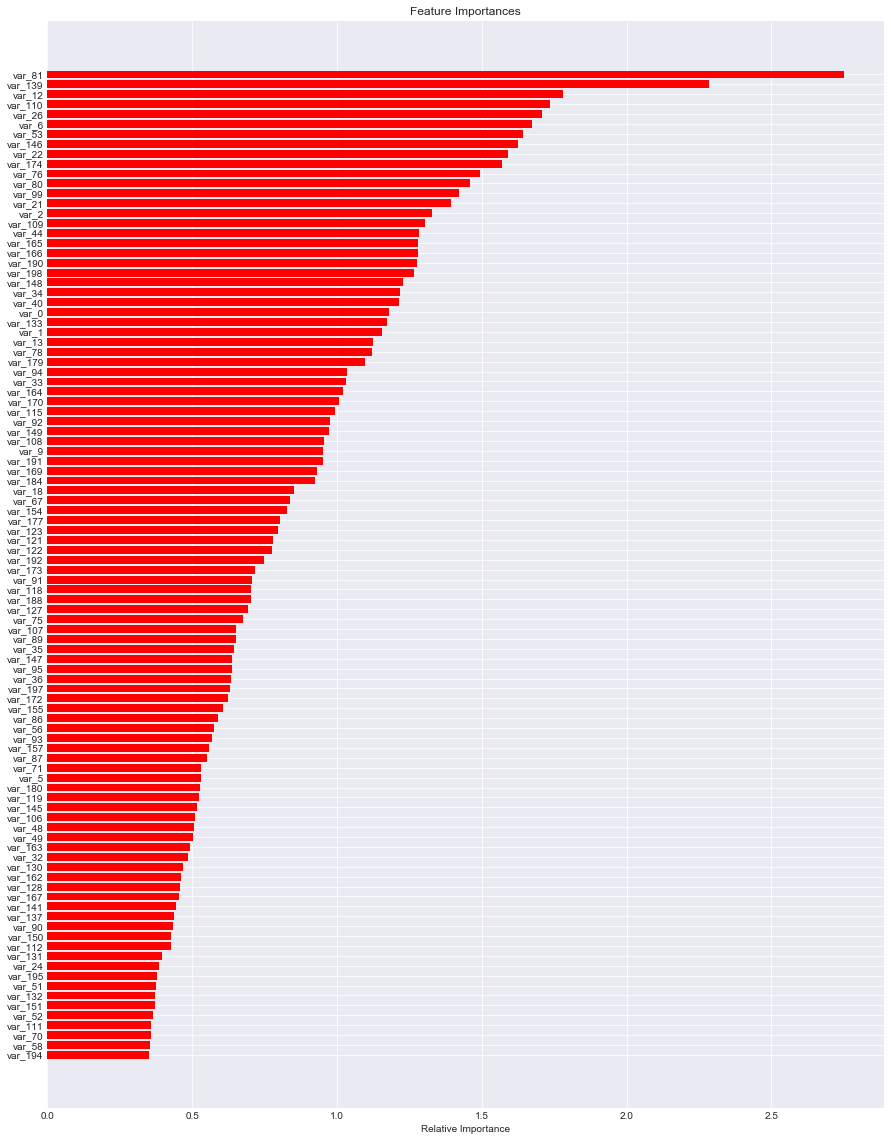

In [43]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-100:]
plt.figure(figsize=(15,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## For test data

In [44]:
df_test = pd.read_csv("test.csv")

In [45]:
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [46]:
# Checking null value
df_test.isna().sum().any()

False

In [47]:
# Check duplicates values 
print('No of duplicates in test: {}'.format(sum(df_test.drop(['ID_code'], axis=1).duplicated())))

No of duplicates in test: 0


In [48]:
train_x = df.drop(['ID_code','target'],axis=1)
train_y = df['target']

In [49]:
test_x = df_test.drop(['ID_code'],axis=1)

In [63]:
clf1 = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
                         colsample_bytree=0.8400362967290745, gamma=0.004483331345083044,
                         importance_type='split', learning_rate=0.07020278445544602,
                         max_depth=11, min_child_samples=20, min_child_weight=1,
                         min_split_gain=0.0, n_estimators=367, n_jobs=-1, num_leaves=31,
                         objective='binary', random_state=None, reg_alpha=2,
                         reg_lambda=171, silent=True, subsample=0.8103275853858888,
                         subsample_for_bin=200000, subsample_freq=0)
clf1.fit(train_x,train_y)
y_train_pred1 = clf1.predict_proba(train_x)[:,1]
y_test_pred1 = clf1.predict_proba(test_x)[:,1]

In [ ]:
clf2 = cb.CatBoostClassifier(colsample_bylevel=0.6694,
                            learning_rate=0.2839,max_depth=2,
                            n_estimators=831,reg_lambda=177)
clf2.fit(train_x,train_y)
y_train_pred2 = clf2.predict_proba(train_x)[:,1]
y_test_pred2 = clf2.predict_proba(test_x)[:,1]

In [68]:
submission_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
submission_df["target"] = (y_test_pred1+y_test_pred2)/2
submission_df.to_csv("lgb+catboost_submission.csv", index=False)

In [50]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Best Hyper Parameter","Train AUC Score","CV AUC Score"]
x.add_row(["LGBMClassifier","colsample_bytree:0.8400,gamma:0.0044,\nlearning_rate:0.0702,max_depth:11,\nmin_child_weight:1,n_estimators:367,\nreg_alpha:2,reg_lambda:171,\nsubsample:0.8103",0.9521,0.8824])
x.add_row(["CatboostClassifier","colsample_bytree:0.66,learning_rate:0.2839,\nmax_depth:2,n_estimators:831,\nreg_lambda:177",0.9124,0.8973])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+--------------------+---------------------------------------------+-----------------+--------------+
|       Model        |             Best Hyper Parameter            | Train AUC Score | CV AUC Score |
+--------------------+---------------------------------------------+-----------------+--------------+
|   LGBMClassifier   |    colsample_bytree:0.8400,gamma:0.0044,    |      0.9521     |    0.8824    |
|                    |      learning_rate:0.0702,max_depth:11,     |                 |              |
|                    |     min_child_weight:1,n_estimators:367,    |                 |              |
|                    |         reg_alpha:2,reg_lambda:171,         |                 |              |
|                    |               subsample:0.8103              |                 |              |
| CatboostClassifier | colsample_bytree:0.66,learning_rate:0.2839, |      0.9124     |    0.8973    |
|                    |        max_depth:2,n_estimators:831,        |              